In [51]:
import copy
from cProfile import label

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader


In [52]:

%matplotlib inline

from pylab import *
import matplotlib.pyplot as plt
import os
import pyAgrum as gum
import pickle

import pyAgrum.lib.ipython as gnb



print('imported')

bn=gum.BayesNet('Causal Graph')


# high_dim=128
high_dim=2


all_nodes=['U1', 'U2', 'Z', 'W', 'X', 'Y']


dim={
    'U1':3,
    'U2':3,
    'Z':2,
    'W':2,
    'X': high_dim,
    'Y':2
}

U1 = bn.add('U1', dim['U1'])
U2 = bn.add('U2', dim['U2'])
Z  = bn.add('Z',  dim['Z'])
W  = bn.add('W',  dim['W'])
X  = bn.add('X',  dim['X'])
Y  = bn.add('Y',  dim['Y'])



print (bn)


bn.addArc(U1,Z)
bn.addArc(U1,Y)

bn.addArc(U2,Z)
bn.addArc(U2,W)
# 
bn.addArc(Z,X)
bn.addArc(Z,W)
bn.addArc(W,Y)
bn.addArc(X,Y)




# gnb.sideBySide(gnb.getBN(bn))

imported
BN{nodes: 6, arcs: 0, domainSize: 144, dim: 8, mem: 112o}


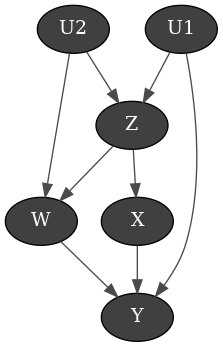

In [53]:
gnb.showBN(bn)  

In [54]:
bn.names()

{'U1', 'U2', 'W', 'X', 'Y', 'Z'}

In [55]:
print(bn.cpt('W').shape)

(2, 3, 2)


# Generate From dirilichlet distribution

# True intervention

In [56]:



# intervened graph         
def get_bn(bn2, intervened):
    for var in intervened:
        for parent in bn2.cpt(var).var_names:
            if parent != var:
                bn2.eraseArc(*(parent, var))

        
        lst = [0 for i in range(dim[var])]
        lst[intervened[var]] = 1
        bn2.cpt(var).fillWith(lst)

    return bn2




In [57]:
# Ground True intervention     

def get_true_causal_effect(bn, treatment='X', outcome='Y'):

    true_intv=[]
    for x in range(dim[treatment]):
        intervened={treatment:x}
        bn_intv=gum.BayesNet(bn)
        bn_intv= get_bn(bn_intv, intervened)
        
        all_nodes=bn_intv.names()
        ie = gum.LazyPropagation(bn_intv)
        var_set = set(all_nodes)
        ie.addJointTarget(var_set)
        ie.makeInference()
        
        pY_dox= ie.evidenceJointImpact([outcome], [])
        
        true_intv+=  list(pY_dox.toarray())
        # gnb.flow.row(pY_dox, captions=[f'P({outcome}|do{intervened})'])
    
    return true_intv


In [58]:

def powerset(s):
    
    lst=[]
    x = len(s)
    for i in range(1 << x):
        lst.append([s[j] for j in range(x) if (i & (1 << j))])

    return lst
    
# all_adj
# powerset(all_adj)

In [97]:
import math
import numpy as np
from scipy.special import xlogy
import scipy.stats as stats
import matplotlib.pyplot as plt

## set seed
# np.random.seed(0)


while(True):


    ## Gernerate distributions according to the graphical model
    dir_parm= 0.5 # initially 0.1
    
    
    pu1 = stats.dirichlet.rvs([dir_parm]* dim['U1'], size=1)
    pu2 = stats.dirichlet.rvs([dir_parm]* dim['U2'], size=1)
    
    pz = stats.dirichlet.rvs([dir_parm]*dim['Z'], size=dim['U1']*dim['U2'])
    
    pw = stats.dirichlet.rvs([dir_parm]*dim['W'], size=dim['U2']*dim['Z'])
    
    px = stats.dirichlet.rvs([dir_parm] * dim['X'], size=dim['Z'])
    py = stats.dirichlet.rvs([dir_parm] * dim['Y'], size=dim['U1']*dim['W']* dim['X'])
    
    
    pu1= np.squeeze(pu1, axis=None)
    pu2= np.squeeze(pu2, axis=None)
    bn.cpt('U1').fillWith(pu1) 
    bn.cpt('U2').fillWith(pu2) 
    
    
    bn.cpt('Z')[:]= pz.reshape((dim['U1'], dim['U2'], dim['Z']))
    bn.cpt('Z')
    
    bn.cpt('W')[:]= pw.reshape((dim['Z'], dim['U2'],  dim['W']))
    bn.cpt('W')
    
    
    bn.cpt('X')[:]= px.reshape((dim['Z'], dim['X']))
    bn.cpt('X')
    
    
    
    bn.cpt('Y')[:]= py.reshape(( dim['X'],  dim['W'], dim['U1'], dim['Y'] )) # if dme
    bn.cpt('Y')
    
    
    # Joint distribution
    ie=gum.LazyPropagation(bn)
    ie.makeInference()
    
    
    py_z= ie.evidenceJointImpact(['Y'], ['Z'])
    # gnb.flow.row(ie.evidenceJointImpact(['Y'], ['Z']), captions=[f'P(y|z)'])
    
    
    
    # True causal effect
    true_intv = get_true_causal_effect(bn, treatment='Z', outcome='Y')
    
    
    
    
    sum=0
    for iter, value in enumerate(true_intv):
        sum+=  abs(np.array(py_z.toarray()).reshape(1,-1)[0][iter] - true_intv[iter])
    
    print(sum)
    
    if sum/2 >0.40:
        break

0.15640708195339614
0.025091447845944026
0.18957834077587604
0.1680198409960392
0.13969333359512337
0.032938045570918534
0.04488117801338567
0.02966211536522312
0.07054897550783051
0.35537051157255445
0.34645292276501305
0.24317085352533496
0.05942606532122191
0.12701300147782335
0.10153763117222112
0.08445569751478793
0.2108401393191394
0.18067354490788254
0.17848255965643706
0.15420314812958447
0.44997196371963427
0.032389873205139266
0.2276918015366841
0.12680034310704572
0.06299263678900366
0.290053935322681
0.007839558550325226
0.02365649988322155
0.1862013765586656
0.3016438172957149
0.09021503350509341
0.16188614948420488
0.07426720997670044
0.3838764173493885
0.047703184349644906
0.2950037744289071
0.6944949160712246
0.5624389419305347
0.05472171827668926
0.04195567258473758
0.1346870168692041
0.1252234427637205
0.3964275033507991
0.03555599951309113
0.30083737401731003
0.10905321488870912
0.1562608129771606
0.18165781935215947
0.20097735340214193
0.4620957719145912
0.099748125

In [98]:
ie=gum.LazyPropagation(bn)
ie.makeInference()
py_z= ie.evidenceJointImpact(['Y'], ['Z'])
print(py_z)

true_intv = get_true_causal_effect(bn, treatment='Z', outcome='Y')
print(true_intv)


      ||  Y                |
Z     ||0        |1        |
------||---------|---------|
0     || 0.1378  | 0.8622  |
1     || 0.8464  | 0.1536  |

[0.5166492441926079, 0.48335075580739206, 0.8136853579458281, 0.18631464205417186]


In [99]:
bn.cpt('X')

(pyAgrum.Potential<double>@0x5635836ec6d0) 
      ||  X                |
Z     ||0        |1        |
------||---------|---------|
0     || 0.2401  | 0.7599  |
1     || 0.8135  | 0.1865  |

In [100]:
import pickle

bnid=high_dim

save= f'./bn_{bnid}.pickle'
with open(save, 'wb') as handle:
    pickle.dump(bn, handle, protocol=pickle.HIGHEST_PROTOCOL)
save

'./bn_2.pickle'

In [101]:
bn

(pyAgrum.BayesNet<double>@0x5635841542b0) BN{nodes: 6, arcs: 8, domainSize: 144, dim: 33, mem: 512o}

In [102]:
import pickle
# bnid='fedsynthetic'     #  when x is 20 dimensional.

# bnid='x20'     #  when x is 20 dimensional.
bnid=high_dim     #  when x is 64 dimensional.
with open(f'./bn_{bnid}.pickle', 'rb') as handle:
    bn = pickle.load(handle)
    
# bn.cpt('Y')
bnid

2

In [103]:
nC = 5 # number of clients

samples_per_client= 1000

g=gum.BNDatabaseGenerator(bn)
N= (nC)*samples_per_client
g.drawSamples(N,{})
main_dataset= g.to_pandas().astype(int)
main_dataset

,U1,U2,Z,W,X,Y
0,1,0,1,0,1,1
1,1,0,1,0,0,0
2,1,0,1,0,0,0
3,1,0,1,0,1,0
4,1,0,1,0,0,0
...,...,...,...,...,...,...
4995,0,0,0,0,0,1
4996,1,0,1,0,0,0
4997,1,0,1,0,1,1
4998,1,0,1,0,0,0


In [106]:
del main_dataset['U1']
del main_dataset['U2']
main_dataset

KeyError: 'U1'

# Generating client data 

In [107]:
data_chunks = np.array_split(main_dataset, nC)  # n chunks for n clients



In [114]:
project_root = '/local/scratch/a/rahman89/PycharmProjects/GenUnseen/MyProjects/CausalFed/FedDCM'
exp_name=f'data/nonid{high_dim}'
save_folder = f'{project_root}/{exp_name}'
os.makedirs(save_folder, exist_ok=True)


In [115]:
for client_no in range(nC):
    save_loc = f'{save_folder}/client{client_no}_data.pkl'
    print('Saving labels at', save_loc)
    with open(save_loc, 'wb') as f:
        pickle.dump(data_chunks[client_no], f)
    
    
    save_loc = f'{save_folder}/client{client_no}_data.csv'        
    data_chunks[client_no].to_csv(save_loc, index=False)


Saving labels at /local/scratch/a/rahman89/PycharmProjects/GenUnseen/MyProjects/CausalFed/FedDCM/data/nonid2/client0_data.pkl
Saving labels at /local/scratch/a/rahman89/PycharmProjects/GenUnseen/MyProjects/CausalFed/FedDCM/data/nonid2/client1_data.pkl
Saving labels at /local/scratch/a/rahman89/PycharmProjects/GenUnseen/MyProjects/CausalFed/FedDCM/data/nonid2/client2_data.pkl
Saving labels at /local/scratch/a/rahman89/PycharmProjects/GenUnseen/MyProjects/CausalFed/FedDCM/data/nonid2/client3_data.pkl
Saving labels at /local/scratch/a/rahman89/PycharmProjects/GenUnseen/MyProjects/CausalFed/FedDCM/data/nonid2/client4_data.pkl


In [116]:
data_chunks[4]

,Z,W,X,Y
4000,1,0,0,0
4001,1,0,0,0
4002,0,1,1,1
4003,1,0,1,1
4004,0,0,1,1
...,...,...,...,...
4995,0,0,0,1
4996,1,0,0,0
4997,1,0,1,1
4998,1,0,0,0


# Creating test dataset

In [117]:
g=gum.BNDatabaseGenerator(bn)
num_test_samples= 1000
N= num_test_samples
g.drawSamples(N,{})
test_dataset= g.to_pandas()
del test_dataset['U1']
del test_dataset['U2']
test_dataset

,Z,W,X,Y
0,1,0,0,0
1,0,1,1,1
2,0,1,1,1
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
995,1,0,1,0
996,1,0,0,0
997,1,0,0,0
998,1,1,0,1


In [118]:
save_loc=  f'{save_folder}/test_data.pkl'

print('Saving labels at', save_loc)
with open(save_loc, 'wb') as f:
    pickle.dump(test_dataset, f)
    
save_loc = f'{save_folder}/test_data.csv'        
data_chunks[client_no].to_csv(save_loc, index=False)

Saving labels at /local/scratch/a/rahman89/PycharmProjects/GenUnseen/MyProjects/CausalFed/FedDCM/data/nonid2/test_data.pkl
